In [3]:
import symforce

symforce.set_symbolic_api("sympy")

import symforce.symbolic as sf
from symforce.notebook_util import display
from symforce import geo
from symforce import values
from symforce.geo.unsupported.pose3_se3 import Pose3_SE3

def n_link_forward_kinematics(joint_angles: values.Values, screw_axes_params: values.Values, M_params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula,
    with symbolic parameters for joint angles, screw axes, and the initial transformation.

    Args:
        joint_angles: A Values object containing symbolic joint angles, with keys "q1", "q2", etc.
        screw_axes_params: A Values object containing symbolic parameters for the screw axes.
                         Each key should be of the form "S{i}", where i is the joint index,
                         and the value should be a 6-vector representing the screw axis [omega_x, omega_y, omega_z, v_x, v_y, v_z].
        M_params: A Values object containing symbolic parameters for the initial transformation matrix M.
                  The keys should be "R" for the rotation (as a 3-vector Euler angles) and "t" for the translation (as a 3-vector).
        epsilon: A small number to handle singularities in Rot3.from_tangent.

    Returns:
        The homogeneous transformation matrix representing the end-effector configuration in the space frame.
    """
    # Construct the initial transformation matrix M from symbolic parameters
    R = geo.Rot3.from_yaw_pitch_roll(*M_params["R"])
    t = geo.V3(M_params["t"])
    M = geo.Pose3(R=R, t=t)

    # Initialize the transformation with M
    T = M

    n = len(joint_angles)

    # Compute the product of exponentials in reverse order
    for i in range(n, 0, -1):  # Start from n and go down to 1
        # Extract screw axis parameters and joint angle from Values objects
        S = screw_axes_params[f"S{i}"]
        q = joint_angles[f"q{i}"]

        # Create se3 element (6x1 vector)
        se3_element = sf.Matrix61(S * q)

        # Create a Pose3_SE3 object from the se3 element
        pose3_se3 = Pose3_SE3.from_tangent(se3_element, epsilon=epsilon)

        # Convert Pose3_SE3 to Pose3
        pose3 = sf.Pose3(R=pose3_se3.R, t=pose3_se3.t)

        # Update the transformation (multiply from the left)
        T = pose3 * T

    # Convert to homogeneous matrix at the end
    return T.to_homogenous_matrix()


# Example usage (adjust as needed for your specific case)
joint_angles = values.Values(
    q1=sf.Symbol("q1"),
    q2=sf.Symbol("q2"),
    q3=sf.Symbol("q3"),
)

screw_axes_params = values.Values(
    S1=sf.V6.symbolic("S1"),
    S2=sf.V6.symbolic("S2"),
    S3=sf.V6.symbolic("S3"),
)

M_params = values.Values(
    R=sf.V3.symbolic("R"),
    t=sf.V3.symbolic("t"),
)

epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

# display("End-Effector Pose:\n")
# display(f"{end_effector_pose}")

'End-Effector Pose:\n'

'Matrix([\n[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Cleaning Small values applied by epsilon

In [5]:
import sympy as sp
from sympy import sympify, maple_code, Symbol

def remove_small_values(expr, threshold=1e-10):
    if isinstance(expr, sp.Number):
        return sp.Float(0) if abs(expr) < threshold else expr
    elif isinstance(expr, sp.Add):
        return sp.Add(*[remove_small_values(arg, threshold) for arg in expr.args])
    elif isinstance(expr, sp.Mul):
        cleaned_args = [remove_small_values(arg, threshold) for arg in expr.args]
        if any(arg == 0 for arg in cleaned_args):
            return sp.Float(0)
        return sp.Mul(*cleaned_args)
    elif isinstance(expr, sp.Pow):
        base = remove_small_values(expr.base, threshold)
        exp = remove_small_values(expr.exp, threshold)
        if exp == 0.5:  # This is a square root
            if isinstance(base, sp.Add):
                significant_terms = [term for term in base.args if not (isinstance(term, sp.Number) and abs(term) < threshold)]
                if len(significant_terms) == 0:
                    return sp.Float(0)
                elif len(significant_terms) == 1:
                    return sp.sqrt(significant_terms[0])
                else:
                    return sp.sqrt(sp.Add(*significant_terms))
            return sp.sqrt(base)
        return base ** exp
    elif isinstance(expr, (sp.sin, sp.cos, sp.tan)):
        return expr.func(remove_small_values(expr.args[0], threshold))
    else:
        return expr

def clean_expression(expr):
    cleaned_expr = remove_small_values(expr)
    return sp.simplify(cleaned_expr)


- `q1`: Output joint angle (revolute)
- `q3`: Input prismatic joint displacement
- `params`: A Values object containing geometric parameters of the mechanism
- `epsilon`: A small number to handle singularities

## Internal Kinematic Chains

The function defines two internal kinematic chains:

1. `chain1(q1)`: Represents the first part of the mechanism, from the base to the end of the first link.
2. `chain2(q2, q3)`: Represents the second part of the mechanism, including the prismatic joint.

These chains use the `n_link_forward_kinematics` function to compute their transformations.

## Loop Closure Condition

The `loop_closure(q1, q2, q3)` function enforces the constraint that both kinematic chains must meet at the same point, forming a closed loop.

## Solving for q1

The function solves for q1 in terms of q3 using the loop closure equations:

1. It sets up symbolic variables for q1, q2, and q3.
2. It applies the loop closure condition and cleans the resulting equations.
3. It uses `sf.solve()` to solve the equations for q1.
4. It extracts all solutions for q1 in terms of q3.

## Computing End-Effector Poses

For each solution of q1, the function computes the corresponding end-effector pose using `chain1`.

## Return Values

The function returns:
1. A list of end-effector poses (`T_sb_list`) for each solution of q1.
2. A dictionary containing:
   - 'q1': List of solutions for q1 in terms of q3
   - 'q3': The original q3 symbol

This function allows for a comprehensive analysis of the slider-crank mechanism's kinematics, providing multiple solutions when they exist and expressing the output joint angle in terms of the input displacement.

'End-Effector Poses:'

'Solution 1:'

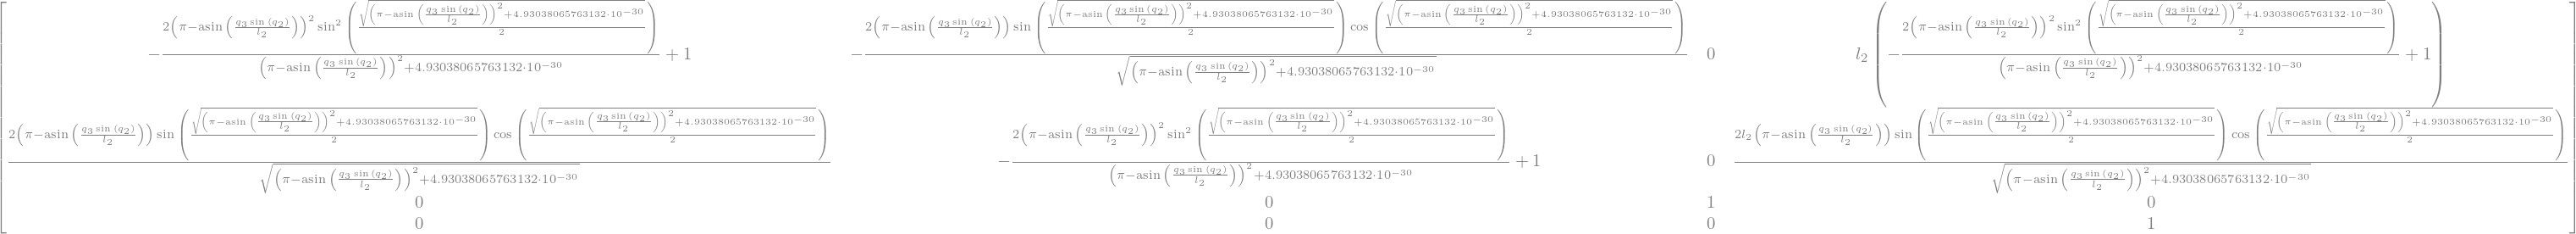

'\n'

'Solution 2:'

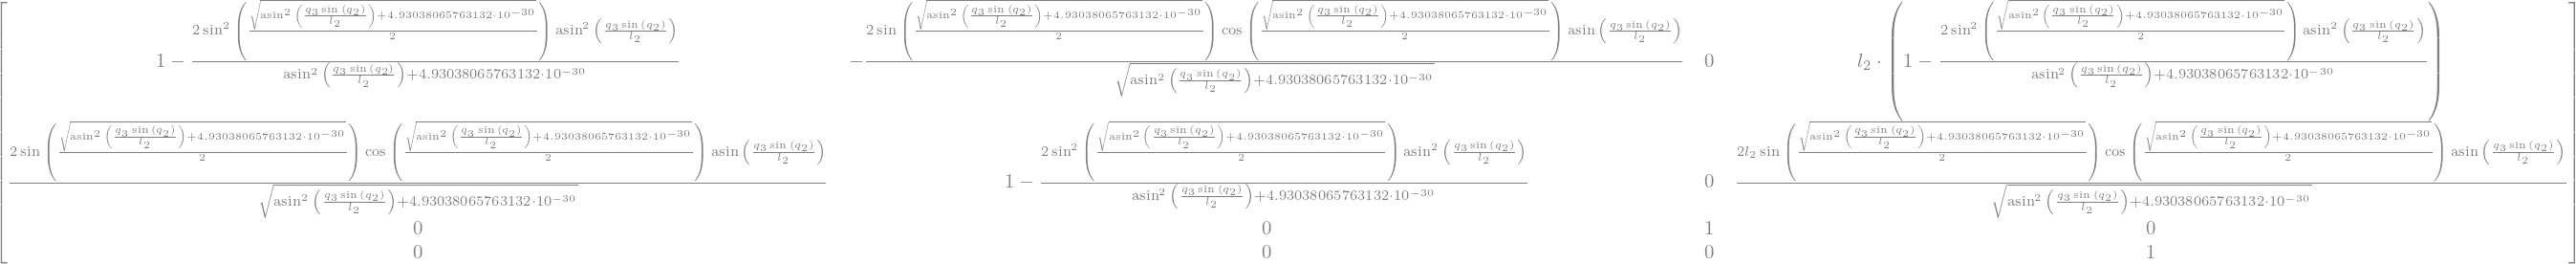

'\n'

'Joint Variables:'

'q1 solutions (in terms of q3):'

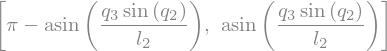

'q3:'

In [33]:
def slider_crank_kinematics(q1: sf.Scalar, q3: sf.Scalar, params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for a slider-crank linkage (1-RRPR) using n_link_forward_kinematics.

    Args:
        q1: Output joint angle (revolute)
        q3: Input prismatic joint displacement
        params: A Values object containing geometric parameters of the mechanism
        epsilon: A small number to handle singularities

    Returns:
        A tuple (T_sb, joint_variables) where T_sb is the end-effector pose and
        joint_variables is a dictionary of all joint variables.
    """
    # Define the kinematic chains using n_link_forward_kinematics
    def chain1(q1):
        joint_angles = values.Values()
        joint_angles['q1'] = q1
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6([0, 0, 1, 0, 0, 0])
        # screw_axes['S2'] = sf.V6([0, 0, 1, -params['l1'], 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l2'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    def chain2(q2,q3):
        joint_angles = values.Values()
        joint_angles['q1'] = q2
        joint_angles['q2'] = q3-params['q3_min']
        # axis of rotation for revolute joint1
        omega1 = sf.V3(0, 0, 1)
        # Calculate v for revolute joint 1
        q1 = sf.V3(params['l1'], 0, 0)  # Point on the axis of joint 1
        v1 = -omega1.cross(q1)
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6(omega1.to_flat_list() + v1.to_flat_list())
        screw_axes['S2'] = sf.V6([0, 0, 0, 1, 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l1']+params['q3_min'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    # Loop-closure condition
    def loop_closure(q1,q2,q3):
        T1 = chain1(q1)
        T2 = chain2(q2, q3)
        # Extract the position vectors from the transformation matrices
        p1 = T1[0:3, 3]
        p2 = T2[0:3, 3]
        # The loop closure condition is that these positions should be equal
        return p1 - p2

        # Solve for q1 in terms of q3 using loop-closure condition
    q1 = sf.Symbol('q1', positive=True)
    q2 = sf.Symbol('q2', positive=True)
    q3 = sf.Symbol('q3', positive=True)
    closure_eqs = loop_closure(q1, q2, q3)
    # Apply clean_expression to each element of closure_eqs
    cleaned_closure_eqs = [sf.simplify(sf.expand(clean_expression(eq))) for eq in closure_eqs]    

    # Solve for q1 in terms of q3
    solution = sf.solve(cleaned_closure_eqs, q1)

    # Extract all solutions for q1 in terms of q3
    q1_solutions = [sol[0] for sol in solution]  # Extract the expression from each tuple

    # Compute final end-effector poses for all solutions
    T_sb_list = [chain1(q1_sol) for q1_sol in q1_solutions]

    return T_sb_list, {'q1': q1_solutions, 'q3': q3}

# Example usage
params = values.Values()
params['q3_min']=sf.Symbol('q3_min',positive=True)
params['l1'] = sf.Symbol('l1',positive=True)
params['l2'] = sf.Symbol('l2',positive=True)
q1 = sf.Symbol('q1',positive=True)
q3 = sf.Symbol('q3',positive=True)
epsilon = sf.numeric_epsilon

T_sb_list, joint_vars = slider_crank_kinematics(q1, q3, params, epsilon)



display("End-Effector Poses:")
for i, T_sb in enumerate(T_sb_list):
    display(f"Solution {i+1}:")
    display(T_sb)
    display("\n")

display("Joint Variables:")
display("q1 solutions (in terms of q3):")
display(joint_vars['q1'])
display("q3:")
display(joint_vars['q3'])

# Inverse Kinematics

'Inverse Kinematics Solutions:'

'q3 solutions (in terms of q1):'

'Solution 1:'

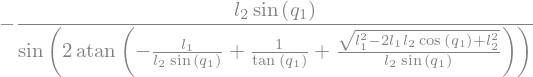

'\n'

'Solution 2:'

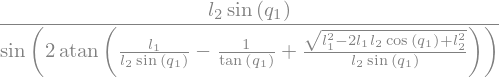

'\n'

'Joint Variables:'

'q1:'

In [38]:
def slider_crank_inverse_kinematics(q1: sf.Scalar, params: values.Values, epsilon: sf.Scalar):
    """
    Computes the inverse kinematics for a slider-crank linkage (1-RRPR) using n_link_forward_kinematics.

    Args:
        q1: Input joint angle (revolute)
        params: A Values object containing geometric parameters of the mechanism
        epsilon: A small number to handle singularities

    Returns:
        A tuple (q3_solutions, joint_variables) where q3_solutions is a list of solutions for q3
        and joint_variables is a dictionary of all joint variables.
    """
    # Define the kinematic chains using n_link_forward_kinematics
    def chain1(q1):
        joint_angles = values.Values()
        joint_angles['q1'] = q1
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6([0, 0, 1, 0, 0, 0])
        # screw_axes['S2'] = sf.V6([0, 0, 1, -params['l1'], 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l2'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    def chain2(q2,q3):
        joint_angles = values.Values()
        joint_angles['q1'] = q2
        joint_angles['q2'] = q3-params['q3_min']
        # axis of rotation for revolute joint1
        omega1 = sf.V3(0, 0, 1)
        # Calculate v for revolute joint 1
        q1 = sf.V3(params['l1'], 0, 0)  # Point on the axis of joint 1
        v1 = -omega1.cross(q1)
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6(omega1.to_flat_list() + v1.to_flat_list())
        screw_axes['S2'] = sf.V6([0, 0, 0, 1, 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l1']+params['q3_min'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
        # Loop-closure condition
    def loop_closure(q1,q2,q3):
        T1 = chain1(q1)
        T2 = chain2(q2, q3)
        # Extract the position vectors from the transformation matrices
        p1 = T1[0:3, 3]
        p2 = T2[0:3, 3]
        # The loop closure condition is that these positions should be equal
        return p1 - p2

    # Solve for q3 in terms of q1 using loop-closure condition
    q1 = sf.Symbol('q1', positive=True)
    q2 = sf.Symbol('q2', positive=True)
    q3 = sf.Symbol('q3', positive=True)
    closure_eqs = loop_closure(q1, q2, q3)
    cleaned_closure_eqs = [sf.simplify(sf.expand(clean_expression(eq))) for eq in closure_eqs]    

    # Solve for q3 in terms of q1
    solution = sf.solve(cleaned_closure_eqs, [q3,q2])

    # Extract all solutions for q3 in terms of q1
    q3_solutions = [sol[0] for sol in solution]

    return q3_solutions, {'q1': q1, 'q3': q3_solutions}

# Example usage
params = values.Values()
params['q3_min'] = sf.Symbol('q3_min', positive=True)
params['l1'] = sf.Symbol('l1', positive=True)
params['l2'] = sf.Symbol('l2', positive=True)
q1 = sf.Symbol('q1', positive=True)
epsilon = sf.numeric_epsilon

q3_solutions, joint_vars = slider_crank_inverse_kinematics(q1, params, epsilon)

display("Inverse Kinematics Solutions:")
display("q3 solutions (in terms of q1):")
for i, sol in enumerate(q3_solutions):
    display(f"Solution {i+1}:")
    display(sol)
    display("\n")

display("Joint Variables:")
display("q1:")
display(joint_vars['q1'])